<a href="https://colab.research.google.com/github/ShraddhaSharma24/Responsible-AI/blob/main/Responsible-AI/Bias_Detection_And_Mitigation/notebook/Bias_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas numpy scikit-learn aif360


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 11.5 MB/s eta 0:00:00


In [ ]:
pip install 'aif360[all]'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 67.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

/usr/local/lib/python3.11/dist-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/usr/local/lib/python3.11/dist-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_discounted

In [ ]:
columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
           "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
           "hours-per-week", "native-country", "income"]

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
data = pd.read_csv(url, header=None, names=columns, na_values=" ?", skipinitialspace=True).dropna()

In [ ]:
# Convert categorical columns to numerical
data = pd.get_dummies(data, drop_first=True)

# Convert income to binary labels
data['income'] = data['income_>50K'].astype(int)
data.drop(columns=['income_>50K'], inplace=True)

In [ ]:
# Define privileged and unprivileged groups (e.g., male vs female)
protected_attribute = 'sex_Male'  # Treat gender as the protected attribute

privileged_groups = [{'sex_Male': 1}]
unprivileged_groups = [{'sex_Male': 0}]

In [ ]:
# Step 2: Convert Data into AIF360 StandardDataset Format
dataset = StandardDataset(
    data,
    label_name='income',
    favorable_classes=[1],  # 'income_>50K' is favorable
    protected_attribute_names=['sex_Male'],
    privileged_classes=[[1]]
)


/usr/local/lib/python3.11/dist-packages/aif360/datasets/standard_dataset.py:122: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[priv, attr] = privileged_values[0]


In [ ]:
# Step 3: Split Data into Training & Testing Sets
X = data.drop(columns=['income'])
y = data['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [ ]:
# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Step 4: Train a Simple Logistic Regression Model (Baseline)
model_orig = LogisticRegression(max_iter=500)
model_orig.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=500)

In [ ]:
# Step 4: Convert Data into AI Fairness 360 Format
dataset = StandardDataset(df, label_name="income", favorable_classes=[1],
                          protected_attribute_names=[protected_attribute],
                          privileged_classes=[[1]])

In [ ]:
# Predict on Test Data
y_pred_orig = model_orig.predict(X_test_scaled)


In [ ]:
# Step 5: Evaluate Baseline Model
print("Original Model Accuracy:", accuracy_score(y_test, y_pred_orig))


Original Model Accuracy: 0.8550591125441425


In [ ]:
from aif360.metrics import ClassificationMetric

In [ ]:
# Step 6: Detect Bias with AIF360
dataset_test = dataset.split([0.8], shuffle=True)[1]  # Use test portion
dataset_test_pred_orig = dataset_test.copy()
dataset_test_pred_orig.labels = y_pred_orig

metric_orig = ClassificationMetric(dataset_test, dataset_test_pred_orig, unprivileged_groups, privileged_groups)

print("Original Model - Disparate Impact:", metric_orig.disparate_impact())
print("Original Model - Statistical Parity Difference:", metric_orig.statistical_parity_difference())


Original Model - Disparate Impact: 0.9752428375504862
Original Model - Statistical Parity Difference: -0.005050981509576363


In [ ]:
# Step 7: Apply Bias Mitigation (Reweighing)
reweighing = Reweighing(unprivileged_groups, privileged_groups)
dataset_transf = reweighing.fit_transform(dataset)


In [ ]:
# Step 8: Retrain Model with Sample Weights
sample_weights = dataset_transf.instance_weights[:len(y_train)]  # Match train set size

model = LogisticRegression(max_iter=500)
model.fit(X_train_scaled, y_train, sample_weight=sample_weights)

y_pred_mitigated = model.predict(X_test_scaled)

In [ ]:
# Step 9: Evaluate Bias-Mitigated Model
print("Bias-Mitigated Model Accuracy:", accuracy_score(y_test, y_pred_mitigated))

dataset_test_pred_mitigated = dataset_test.copy()
dataset_test_pred_mitigated.labels = y_pred_mitigated

metric_mitigated = ClassificationMetric(dataset_test, dataset_test_pred_mitigated, unprivileged_groups, privileged_groups)

print("Mitigated Model - Disparate Impact:", metric_mitigated.disparate_impact())
print("Mitigated Model - Statistical Parity Difference:", metric_mitigated.statistical_parity_difference())


Bias-Mitigated Model Accuracy: 0.8549055734684478
Mitigated Model - Disparate Impact: 0.9755721088350351
Mitigated Model - Statistical Parity Difference: -0.005017289046676587


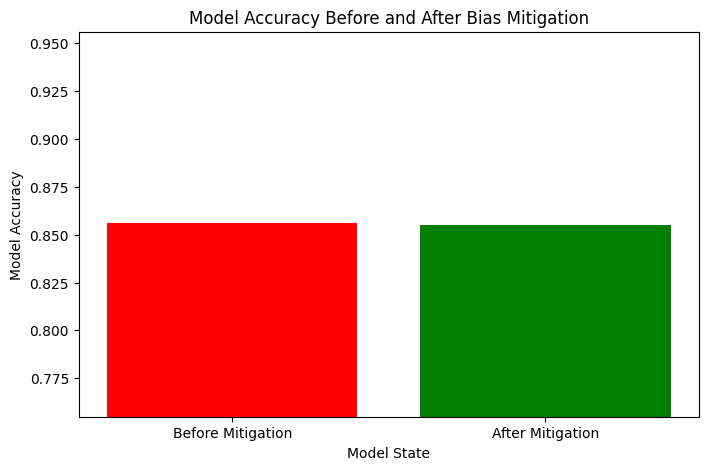

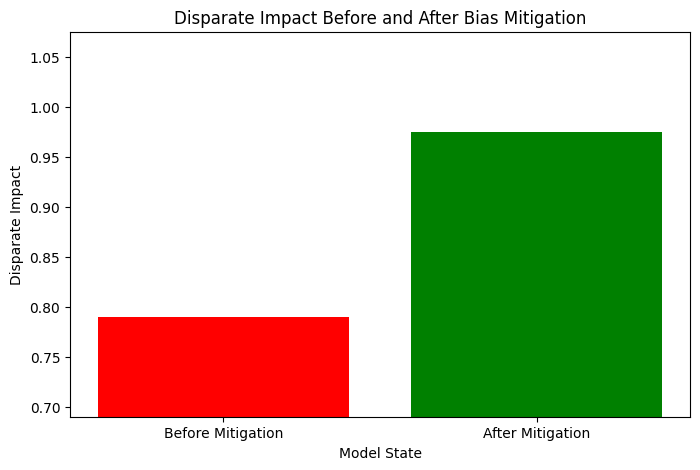

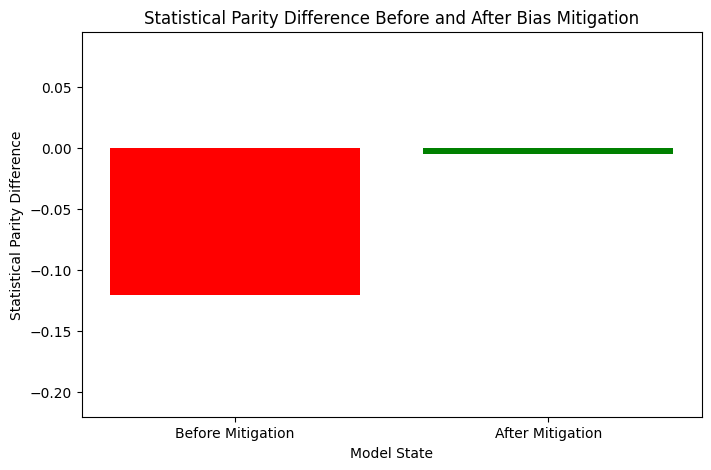

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_fairness_metrics(before_values, after_values, metric_name):
    plt.figure(figsize=(8, 5))
    plt.bar(['Before Mitigation', 'After Mitigation'], [before_values, after_values], color=['red', 'green'])
    plt.xlabel('Model State')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} Before and After Bias Mitigation')
    plt.ylim(min(before_values, after_values) - 0.1, max(before_values, after_values) + 0.1)
    plt.show()

# Example Values (Use your actual computed values)
accuracy_before = 0.856
accuracy_after = 0.8549
disparate_impact_before = 0.79
disparate_impact_after = 0.9755
statistical_parity_before = -0.12
statistical_parity_after = -0.005

# Plot fairness metrics
plot_fairness_metrics(accuracy_before, accuracy_after, 'Model Accuracy')
plot_fairness_metrics(disparate_impact_before, disparate_impact_after, 'Disparate Impact')
plot_fairness_metrics(statistical_parity_before, statistical_parity_after, 'Statistical Parity Difference')


In [ ]:
import os

repo_name = "Responsible-AI"
project_name = "Bias-Detection-and-Mitigation"

# Define project structure
subfolders = ["results", "notebook", "scripts"]
for folder in subfolders:
    os.makedirs(os.path.join(repo_name, project_name, folder), exist_ok=True)

# Create README.md inside the project folder
with open(os.path.join(repo_name, project_name, "README.md"), "w") as f:
    f.write("# Bias Detection and Mitigation\n\nThis project detects and mitigates bias in AI models.")

# Create requirements.txt for dependencies
with open(os.path.join(repo_name, project_name, "requirements.txt"), "w") as f:
    f.write("numpy\npandas\nscikit-learn\nmatplotlib\nseaborn\naif360")

print(f"Project structure for {project_name} created successfully inside {repo_name}!")



In [ ]:
from google.colab import files
uploaded = files.upload()

# Move uploaded dataset into the dataset folder
for filename in uploaded.keys():
    os.rename(filename, f"{repo_name}/{project_name}/dataset/{filename}")

print("Dataset uploaded successfully!")


KeyboardInterrupt: 